In [58]:
# imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl
import lightning.pytorch.callbacks as pl_callbacks

from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from torchmetrics import F1Score

import numpy as np

from typing import cast

import os
is_linux = os.name == 'posix'

In [59]:
# import data
from spotify_data import grouped_data, categorical_columns, string_columns

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/ketexon/programming/csm148-spotiflies/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [61]:
response_variable = "track_genre"

# remove string columns and one-hot encode
Y = grouped_data[response_variable]
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

X = grouped_data.drop(columns=[response_variable, *string_columns])
X = pd.get_dummies(
    X,
    columns=[col for col in categorical_columns if col != response_variable],
    drop_first=True
)

# split data
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_encoded,
    test_size=0.2,
    random_state=42
)

Y_train = cast(np.ndarray, Y_train)

# create class weights
Y_train_unique = np.unique(Y_train, return_counts=True)
print(Y_train_unique)
class_weights = len(Y_train) / (Y_train_unique[1] * len(Y_train_unique[1]))
for i, w in enumerate(class_weights):
    label_encoded = Y_train_unique[0][i]
    label_decoded = label_encoder.inverse_transform([label_encoded])[0]
    w_str = f"{w:.3f}"
    count_str = f"{Y_train_unique[1][i]:,}"
    print(f"{label_decoded + ':': <16}{w_str: <16}{count_str}")
print(Y.value_counts())
# DEBUG: fill Y_train with all 2s
# Y_train = [2] * len(Y_train)
# Y_val = [2] * len(Y_val)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long).to(device)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# create dataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

# create dataloaders
batch_size = 64
num_workers = 12 if is_linux else 0
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 2388, 15974,  4782,  2422,  3169,  4797, 23924,  7174,  8769,
       17663]))
classical:      3.813           2,388
electronic:     0.570           15,974
folk:           1.904           4,782
hip-hop:        3.760           2,422
jazz:           2.874           3,169
metal:          1.898           4,797
misc:           0.381           23,924
pop:            1.269           7,174
rock:           1.038           8,769
world:          0.516           17,663
track_genre
misc          29855
world         21984
electronic    20000
rock          10996
pop            8999
metal          6000
folk           6000
jazz           3999
hip-hop        3000
classical      2995
Name: count, dtype: int64


In [62]:
# Create model

import torchmetrics.classification


class SpotifyModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        lr: float = 0.01,
        class_weights: torch.tensor = None,
        hidden_dim: int = 64,
        dropout_rate: float = 0.5,
        weight_decay: float = 0.01,
    ):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        self.n_classes = output_dim
        self.weight_decay = weight_decay
        self.epoch_metrics = []
        self.train_metrics_stack = []
        self.validation_metrics_stack = []
        self.loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        self.train_metrics_stack.append({
            'train_loss': loss,
        })
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.validation_metrics_stack.append({
            'val_loss': loss,
            'val_acc': acc
        })
        self.log("val_loss", loss)
        return loss

    def on_validation_epoch_end(self):
        # sum in validation stack
        if len(self.validation_metrics_stack) == 0:
            return
        if len(self.train_metrics_stack) == 0:
            return
        val_loss = torch.stack([x['val_loss'] for x in self.validation_metrics_stack]).mean()
        val_acc = torch.stack([x['val_acc'] for x in self.validation_metrics_stack]).mean()
        train_loss = torch.stack([x['train_loss'] for x in self.train_metrics_stack]).mean()
        self.epoch_metrics.append({
            'val_loss': val_loss.cpu(),
            'val_acc': val_acc.cpu(),
            'train_loss': train_loss.cpu(),
        })
        # clear stack
        self.validation_metrics_stack = []
        self.train_metrics_stack = []


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]


In [63]:
input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
lr = 0.01

model = SpotifyModel(
    input_dim,
    output_dim,
    lr=lr,
    class_weights=class_weights_tensor
).to(device)

# train model
early_stopping = pl_callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min'
)

use_checkpoint = False
ckpt_path="epoch=99-step=142300.ckpt" if use_checkpoint else None
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        early_stopping
    ]
)
trainer.fit(
    model,
    train_loader,
    validation_loader,
    ckpt_path=ckpt_path
)

/home/ketexon/programming/csm148-spotiflies/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Sequential       | 2.5 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 1423/1423 [00:13<00:00, 106.60it/s, v_num=18]     


In [64]:
# evaluate model
model.eval()
with torch.no_grad():
    outputs = model.to(device)(X_val_tensor.to(device)).cpu()
    _, predicted = torch.max(outputs.data, 1)
    print(pd.DataFrame(predicted).value_counts())
    class_report = classification_report(
        Y_val,
        predicted,
        labels=range(len(label_encoder.classes_)),
        target_names=label_encoder.classes_,
        zero_division=1
    )
model.train()

print(class_report)

0
1    7657
5    7167
2    4126
0    3816
Name: count, dtype: int64
              precision    recall  f1-score   support

   classical       0.12      0.73      0.20       607
  electronic       0.31      0.60      0.41      4026
        folk       0.13      0.42      0.19      1218
     hip-hop       1.00      0.00      0.00       578
        jazz       1.00      0.00      0.00       830
       metal       0.16      0.93      0.27      1203
        misc       1.00      0.00      0.00      5931
         pop       1.00      0.00      0.00      1825
        rock       1.00      0.00      0.00      2227
       world       1.00      0.00      0.00      4321

    accuracy                           0.20     22766
   macro avg       0.67      0.27      0.11     22766
weighted avg       0.76      0.20      0.10     22766



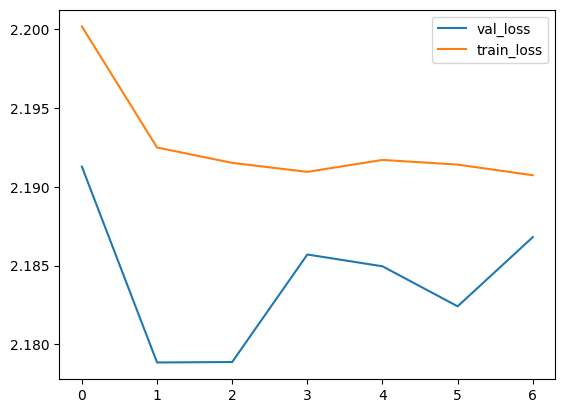

In [65]:
# Graph epoch metrics
import matplotlib.pyplot as plt

# plot epoch to val loss and train loss
plt.plot([x['val_loss'].cpu() for x in model.epoch_metrics], label='val_loss')
plt.plot([x['train_loss'].cpu() for x in model.epoch_metrics], label='train_loss')
plt.legend()
plt.show()


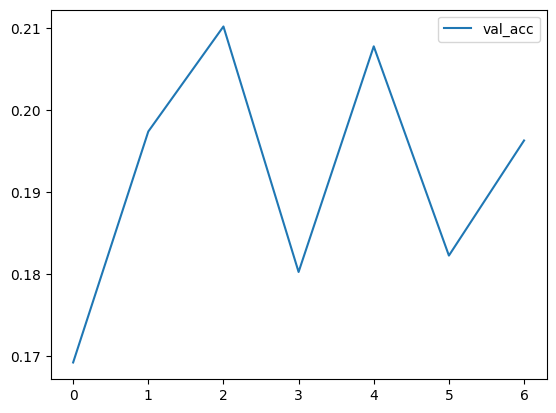

In [66]:
# plot accuracy per epoch
plt.plot([x['val_acc'].cpu() for x in model.epoch_metrics], label='val_acc')
plt.legend()
plt.show()